In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
import numpy as np 
import time
import random
from collections import deque
import tensorflow as tf
from tqdm import tqdm 
from tensorflow.keras import Sequential 
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
import math
import PIL.Image
from tensorflow.keras import backend as K
import cv2
import segmentation_models as sm
from IPython import display
import copy
from skimage.color import rgb2gray
import random
import gc



2024-03-01 03:53:53.040751: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-01 03:53:53.063536: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-01 03:53:53.063559: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-01 03:53:53.064209: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-01 03:53:53.068024: I tensorflow/core/platform/cpu_feature_guar

Segmentation Models: using `keras` framework.


In [2]:
# import tensorflow as tf
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#   tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


2024-03-01 03:53:53.983599: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-01 03:53:54.006519: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-01 03:53:54.006634: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# Data Collection and Preprocessing


In [4]:
N_IMAGES=5000

In [5]:
img_path=r'/home/bhavik/Desktop/Pratik/brats_dataset/images/brats2020flair/'
mask_path=r'/home/bhavik/Desktop/Pratik/brats_dataset/masks/brats2020mask/'

In [6]:
images=[]
masks=[]

In [65]:
def get_images(img_path=img_path,mask_path=mask_path,number=5000,threshold=0.01):
    #storing 5000 images and masks in the lists images and masks. Only storing those images in which masked region is greater than 1% 
    #and combining different mask calsses into one
    images=[]
    masks=[]
    grays=[]
    for root, dirs, files in os.walk(img_path,mask_path):
        print(len(files))
        for i,name in enumerate(files):
            image_path = img_path+name
            msk_path=mask_path+name.replace("flair","seg")
            try:
                image = PIL.Image.open(image_path)
                mask=PIL.Image.open(msk_path)
                # Convert the mask to grayscale.
                gray_mask = np.mean(mask.convert('RGB'), axis=2)
                # Resize the mask to 240x240x1.
                
                resized_mask = np.resize(gray_mask, (240, 240,1))
                val, counts = np.unique(resized_mask, return_counts=True)
                if (1 - (counts[0]/counts.sum())) > threshold:
                    images.append(np.array(image.convert('RGB'))/255)
                    masks.append(np.array(resized_mask)/255)
                    grays.append(rgb2gray(np.array(image.convert('RGB'))/255))
            except:
                continue
            if len(images)==number-1:
                break
    images_array=np.array(images)
    masks_array=np.array(masks)
    bw_images_array=np.array(grays)
    unique_values=np.unique(masks_array[:100])
    masks_array[masks_array==unique_values[1]]=1
    masks_array[masks_array==unique_values[2]]=1

    del images,masks
    return images_array,masks_array,bw_images_array

In [66]:
images_array, masks_array,bw_images_array=get_images(img_path=img_path,mask_path=mask_path,number=N_IMAGES,threshold=0.01)

57196


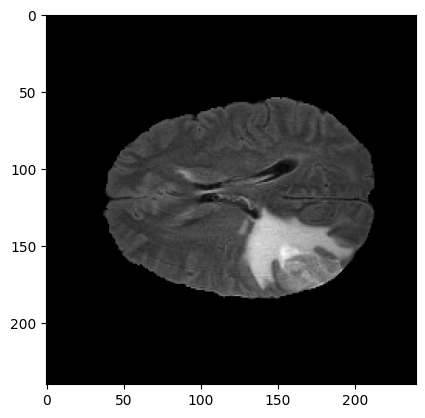

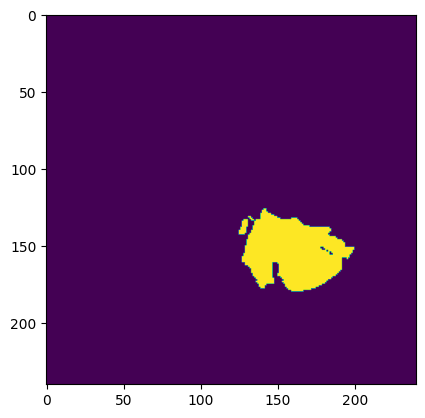

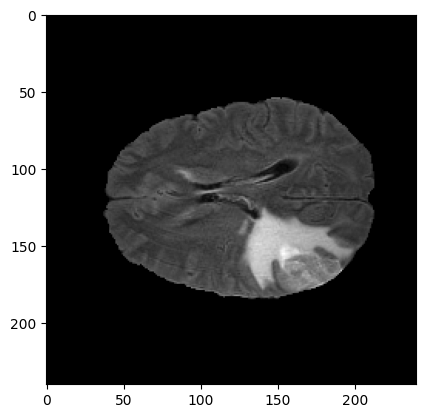

In [67]:
plt.imshow(images_array[0])
plt.show()
plt.imshow(masks_array[0])
plt.show()
plt.imshow(bw_images_array[0],cmap='gray')

In [10]:
val, counts = np.unique(masks_array[0], return_counts=True)
print(val)
print(counts)

[0. 1.]
[55116  2484]


In [11]:
#converting mask class to one hot encoded vector
from keras.utils import to_categorical
masks_cat = to_categorical(masks_array, num_classes=2)
masks_cat.shape

(4999, 240, 240, 2)

In [70]:
#train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test,bw_train,bw_test = train_test_split(images_array, masks_cat, bw_images_array, test_size = 0.25, shuffle=False,stratify=None)

In [13]:
IMG_HEIGHT = images_array.shape[1]
IMG_WIDTH  = images_array.shape[2]
IMG_CHANNELS = images_array.shape[3]
print(IMG_HEIGHT)
print(IMG_WIDTH)
print(IMG_CHANNELS)

240
240
3


# Unet Model

In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU

kernel_initializer =  'he_uniform'

In [15]:
def multi_unet_model(n_classes=2, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()
    
    return model

In [16]:
#dice loss
dice_loss = sm.losses.DiceLoss()

In [17]:
unet_model=multi_unet_model(n_classes=2,IMG_HEIGHT=IMG_HEIGHT,IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

2024-03-01 03:54:33.492291: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-01 03:54:33.492432: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-01 03:54:33.492482: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [18]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss=dice_loss,metrics=['accuracy'])

# Combined Custom Model to train Unet with inputs from DQN

In [19]:
class Complete_Model(tf.keras.Model):
    def __init__(self,unet):
        super(Complete_Model, self).__init__()
        self.unet=unet
    def call(self,inputs):
        predictions=self.unet(inputs[0])
        # predicted_masks=tf.math.argmax(predictions, axis=-1)
        actions=inputs[1]
        final_predictions=tf.clip_by_value(tf.add(predictions,actions),0,1)
        return final_predictions

    def get_preds(self,input_images):
        return self.unet(input_images)
    
    def train_unet(self,X,y):
        loss=self.unet.train_on_batch(X,y,return_dict=True)
        return loss
    

In [20]:
loss_fn=dice_loss

@tf.function  
def train( model,input_images,y_train,actions,opt,loss_fn=loss_fn):
  with tf.GradientTape() as tape:
    output=model([input_images,actions])
    loss=loss_fn(output,y_train)
    gradients = tape.gradient(loss, model.trainable_variables)
  gradient_variables = zip(gradients, model.trainable_variables)
  opt.apply_gradients(gradient_variables)
  return loss

In [21]:
complete_model=Complete_Model(unet_model)
opt= tf.keras.optimizers.Adam(learning_rate=1e-5)

# DQN and RL functions

In [22]:
GAMMA = 0.99
LEARNING_RATE = 1e-6

MEMORY_SIZE = 1000
BATCH_SIZE = 32

EPSILON_MAX = 1.0
EPSILON_MIN = 0.01
EXPLORATION_DECAY = 0.99

In [23]:
state_space=10 #10 dimensional state space
action_space=3 #3 action [-0.1,0,0.1]
all_actions=[-0.1,0,0.1]
intermediate_dim=16

In [24]:
class QModel:
    def __init__(self, input_dim, output_dim, lr):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.lr = lr
        self.Qpolicy = self.create()
        self.Qtarget = self.create() 
        self.Qtarget.set_weights(self.Qpolicy.get_weights())
        
    def create(self):
        model = Sequential()
        model.add(tf.keras.layers.InputLayer(input_shape=(1,state_space)))
        model.add(Dense(512,activation = 'relu'))
        model.add(Dense(256, activation = 'relu'))
        model.add(Dense(128, activation = 'relu'))
        model.add(Dense(self.output_dim, activation = 'linear'))
        model.compile(optimizer =tf.keras.optimizers.legacy.Adam(learning_rate=self.lr), loss = "mse", metrics = ['accuracy'])
        return model

In [25]:
class DQNSolver:
    def __init__(self,state_space,action_space, decay_coe = 0.99, 
                  memory_size = MEMORY_SIZE,EXPLORATION_DECAY=EXPLORATION_DECAY,LEARNING_RATE=LEARNING_RATE,EPSILON_MAX=EPSILON_MAX,EPSILON_MIN=EPSILON_MIN,BATCH_SIZE=BATCH_SIZE):
        
        #self.env = gym.make('CartPole-v0')

        self.states = state_space
        self.n_actions = action_space
        
        self.actions = [i for i in range(self.n_actions)]
        
        self.lr = LEARNING_RATE
        self.gamma = GAMMA
        self.epsilon = EPSILON_MAX
        self.decay_coe = decay_coe
        self.min_eps = EPSILON_MIN
        #self.episodes = episodes
        self.batch_size = BATCH_SIZE
        self.memory = deque(maxlen = memory_size) # replay memory 
        
        self.terminal_state = False # end of the episode
        self.target_counter = 0 
        
        # Plot data
        #self.timestep = self.episodes / 10

        
        
        
        self.model = QModel((1,self.states), self.n_actions, self.lr)
        # Smooth epsilon 
        # self.a = 0.35
        # self.b = 0.1
        # self.c = 0.01
        
    def state_shape(self,states):
        states = np.array(states)
        return states.reshape(-1,*states.shape)
    def update_target_model(self):
        """
        Updates the current target_q_net with the q_net which brings all the
        training in the q_net to the target_q_net.
        :return: None
        """
        self.model.Qtarget.set_weights(self.model.Qpolicy.get_weights())
    def decrement_epsilon(self):
        '''
        if self.epsilon > self.min_eps:
            self.epsilon *= self.decay_coe
        else:
            self.epsilon = self.min_eps
        '''
        # s_time = (time - self.a*self.episodes) / (self.b*self.episodes) 
        # cosh = np.cosh(math.exp(-s_time))
        # self.epsilon = 1 - (1/cosh + (time*self.c/self.episodes))
        if self.epsilon>self.min_eps:
            self.epsilon*=EXPLORATION_DECAY
        else:
            self.epsilon=self.min_eps
    def forget(self):
        self.memory.clear()

    def remember(self, s, a, r, s_, done):
        self.memory.append([self.state_shape(s), a, r, self.state_shape(s_), done])
        
    def act(self, states):
        if np.random.random() > (1 - self.epsilon):
            action = np.random.choice(self.actions)
        else:
            states = self.state_shape(states)
            states.reshape(1,1,self.states)
#             states=[states]
#             states=np.array(states)
            #print(states.shape)
            action = np.argmax(np.array(self.model.Qpolicy.predict_on_batch(states)))
            
        return action
            
    def minibatch(self):
        return random.sample(self.memory, self.batch_size)
        
    

        #plt.savefig(r'RL/loss - e{}v2.png'.format(episode), dpi = 500)
        
    def train(self):
        # X - states passed to the NN, y - target
        
        X, y = [], []
        
        if len(self.memory) >= self.batch_size: 
            SARS = self.minibatch()
            s =np.array( [row[0] for row in SARS])
            s=s.reshape(BATCH_SIZE,1,state_space)
            #print(s.shape)
            qvalue = np.array(self.model.Qpolicy.predict_on_batch(s))
            #print(qvalue)
            s_ =np.array( [row[3] for row in SARS])
            s_=s_.reshape(BATCH_SIZE,1,state_space)
            future_qvalue = np.array(self.model.Qtarget.predict_on_batch(s_))
            #print("2")
            #print(future_qvalue)

            for index, (state, action, reward, state_, done) in enumerate(SARS):
                if done == True:
                    Qtarget = reward
                else:
                    Qtarget = reward + self.gamma * np.max(future_qvalue[index][0])
            
                qcurr = qvalue[index][0]
                #print(qcurr)
                qcurr[int(action)] = Qtarget 
                #print(qcurr)
                X.append(state)
                y.append(qcurr)
#             X_dataset=tf.data.Dataset.from_tensor_slices(X).batch(64)
#             y_dataset=tf.data.Dataset.from_tensor_slices(y).batch(64)
#             final_dataset=tf.data.Dataset.zip((X_dataset, y_dataset))
            X, y = np.array(X).reshape(self.batch_size,1,self.states), np.array(y).reshape(self.batch_size, 1, self.n_actions)
                                 
            loss = self.model.Qpolicy.train_on_batch(X, y,return_dict=True)
            
            

In [26]:
dqn_solver=DQNSolver(state_space=state_space,action_space=action_space)


In [27]:

def step(state,action,ground_truth):
    #step function to get new state and reward based on action taken and current state
    new_state=[]
    all_actions=[-0.1,0,0.1]
    new_state=copy.deepcopy(state)
    new_state[4]=(max(min(state[4]+all_actions[action],1),0))
    # if (new_state[9]==ground_truth) :
    #     reward=1
    # else:
    #     reward=-(ground_truth-new_state[9])**2
    if ((ground_truth-state[4])**2-(ground_truth-new_state[4])**2) >0.001:
        reward=0.1
    elif (((ground_truth-state[4])**2-(ground_truth-new_state[4])**2)<=0.001)and(((ground_truth-state[4])**2-(ground_truth-new_state[4])**2)>=-0.001):
        reward=0
    else:
        reward=-0.1
    # reward=(ground_truth-state[4])**2-(ground_truth-new_state[4])**2 
    #reward function based on if the action taken changes probability of the class 1 towards the ground truth or not
    return [new_state,reward]
    

In [28]:
# #function to get state from image pixel
# def get_state(i,j,unet_output):
#     height=len(unet_output)
#     width=len(unet_output[0])
#     state=[]
#     if i>0 and i< height-1:
#         if j>0 and j<width-1:
#             state.extend(unet_output[i-1,j-1:j+2,1].reshape(3,))
#             state.extend(unet_output[i,j-1:j+2,1].reshape(3,))
#             state.extend(unet_output[i+1,j-1:j+2,1].reshape(3,))
#         elif j==0:
#             state.extend([0])
#             state.extend(unet_output[i-1,j:j+2,1].reshape(2,))
#             state.extend([0])
#             state.extend(unet_output[i,j:j+2,1].reshape(2,))
#             state.extend([0])
#             state.extend(unet_output[i+1,j:j+2,1].reshape(2,))
#         else:
#             state.extend(unet_output[i-1,j-1:j+1,1].reshape(2,))
#             state.extend([0])
#             state.extend(unet_output[i,j-1:j+1,1].reshape(2,))
#             state.extend([0])
#             state.extend(unet_output[i+1,j-1:j+1,1].reshape(2,))
#             state.extend([0])
#     else:
#         if i==0:
#             if j>0 and j<width-1:
#                 state.extend([0,0,0])
#                 state.extend(unet_output[i,j-1:j+2,1].reshape(3,))
#                 state.extend(unet_output[i+1,j-1:j+2,1].reshape(3,))
#             elif j==0:
#                 state.extend([0,0,0])
#                 state.extend([0])
#                 state.extend(unet_output[i,j:j+2,1].reshape(2,))
#                 state.extend([0])
#                 state.extend(unet_output[i+1,j:j+2,1].reshape(2,))
#             else:
#                 state.extend([0,0,0])
#                 state.extend(unet_output[i,j-1:j+1,1].reshape(2,))
#                 state.extend([0])
#                 state.extend(unet_output[i+1,j-1:j+1,1].reshape(2,))
#                 state.extend([0])
#         else:
#             if j>0 and j<width-1:
#                 state.extend(unet_output[i-1,j-1:j+2,1].reshape(3,))
#                 state.extend(unet_output[i,j-1:j+2,1].reshape(3,))
#                 state.extend([0,0,0])
#             elif j==0:
#                 state.extend([0])
#                 state.extend(unet_output[i-1,j:j+2,1].reshape(2,))
#                 state.extend([0])
#                 state.extend(unet_output[i,j:j+2,1].reshape(2,))
#                 state.extend([0,0,0])
#             else:
#                 state.extend(unet_output[i-1,j-1:j+1,1].reshape(2,))
#                 state.extend([0])
#                 state.extend(unet_output[i,j-1:j+1,1].reshape(2,))
#                 state.extend([0])
#                 state.extend([0,0,0])
#     # state.append(predicted_img[i][j])
#     return np.array(state).reshape(9,)


        



In [73]:
#function to get state from image pixel
def get_state(i,j,unet_output,bw_image):
    height=len(bw_image)
    width=len(bw_image[0])
    state=[]
    if i>0 and i< height-1:
        if j>0 and j<width-1:
            state.extend(bw_image[i-1,j-1:j+2].reshape(3,))
            state.extend(bw_image[i,j-1:j+2].reshape(3,))
            state.extend(bw_image[i+1,j-1:j+2].reshape(3,))
        elif j==0:
            state.extend([0])
            state.extend(bw_image[i-1,j:j+2].reshape(2,))
            state.extend([0])
            state.extend(bw_image[i,j:j+2].reshape(2,))
            state.extend([0])
            state.extend(bw_image[i+1,j:j+2].reshape(2,))
        else:
            state.extend(bw_image[i-1,j-1:j+1].reshape(2,))
            state.extend([0])
            state.extend(bw_image[i,j-1:j+1].reshape(2,))
            state.extend([0])
            state.extend(bw_image[i+1,j-1:j+1].reshape(2,))
            state.extend([0])
    else:
        if i==0:
            if j>0 and j<width-1:
                state.extend([0,0,0])
                state.extend(bw_image[i,j-1:j+2].reshape(3,))
                state.extend(bw_image[i+1,j-1:j+2].reshape(3,))
            elif j==0:
                state.extend([0,0,0])
                state.extend([0])
                state.extend(bw_image[i,j:j+2].reshape(2,))
                state.extend([0])
                state.extend(bw_image[i+1,j:j+2].reshape(2,))
            else:
                state.extend([0,0,0])
                state.extend(bw_image[i,j-1:j+1].reshape(2,))
                state.extend([0])
                state.extend(bw_image[i+1,j-1:j+1].reshape(2,))
                state.extend([0])
        else:
            if j>0 and j<width-1:
                state.extend(bw_image[i-1,j-1:j+2].reshape(3,))
                state.extend(bw_image[i,j-1:j+2].reshape(3,))
                state.extend([0,0,0])
            elif j==0:
                state.extend([0])
                state.extend(bw_image[i-1,j:j+2].reshape(2,))
                state.extend([0])
                state.extend(bw_image[i,j:j+2].reshape(2,))
                state.extend([0,0,0])
            else:
                state.extend(bw_image[i-1,j-1:j+1].reshape(2,))
                state.extend([0])
                state.extend(bw_image[i,j-1:j+1].reshape(2,))
                state.extend([0])
                state.extend([0,0,0])
    # state.append(predicted_img[i][j])
    state.append(unet_output[i,j,1])
    return np.array(state).reshape(10,)


        



# Helper Functions

In [29]:
def get_bounding_box(img):
#get bounding box accros tumor segmentation
    left=240
    top=0
    right=0
    bottom=0
    top_flag=0
    
    for i in range(len(img)):
        forward=list(img[i])
        reverse=list(img[i])
        reverse.reverse()
        if (np.max(img[i])!=0 and top_flag==0):
            top=i
            top_flag=1
        if np.max(img[i])!=0:
            bottom=i
            if  forward.index(1)<left:
                left=forward.index(1)
            if len(reverse)-reverse.index(1)-1>right:
                right=len(reverse)-reverse.index(1)-1
        
    del forward
    del reverse
    return left, top, right, bottom




In [30]:
def cropping(indices,unet_model,X_images=X_train,y_images=y_train,bw_images=bw_train,cushion=10):
    #to get cropped images, masks and predictions based on segmentation by Unet
    cropped_images=[]
    cropped_masks=[]
    cropped_predictions=[]
    cropped_predicted_imgs=[]
    predicted_imgs=[]
    cropped_bw_images=[]
    for i in indices:
        cushion=cushion
        left=240
        top=0
        right=0
        bottom=0
        prediction = (unet_model.predict(np.expand_dims(X_images[i],0),verbose=0))
        predicted_img=np.argmax(prediction, axis=3)[0,:,:]
        predicted_imgs.append(predicted_img)
        left, top, right, bottom=get_bounding_box(predicted_img)
        left=max(left-cushion,0)
        right=min(right+cushion,IMG_WIDTH)
        top=max(0,top-cushion)
        bottom=min(bottom+cushion,IMG_HEIGHT)
        cropped_prediction=prediction[0][top:bottom,left:right,:]
        cropped_predictions.append(cropped_prediction)
        cropped_bw_image=bw_images[i][top:bottom,left:right,:]
        cropped_bw_images.append(cropped_bw_image)
        cropped_predicted_img=predicted_img[top:bottom,left:right]
        cropped_image=X_train[i][top:bottom,left:right]
        cropped_mask=np.argmax(y_images[i], axis=-1)[top:bottom,left:right]
        cropped_images.append(cropped_image)
        cropped_masks.append(cropped_mask)
        cropped_predicted_imgs.append(cropped_predicted_img)
        # display.clear_output(wait=True)
    return cropped_images,cropped_masks,cropped_predictions,cropped_predicted_imgs,predicted_imgs,cropped_bw_images

# Final Training Loop

In [31]:
EPOCHS=5
BATCH_SIZE_UNET=2
DQN_TRAINING_SAMPLE_SIZE=500
CUSHION=10

In [32]:
def dqn_training_loop(cropped_images,cropped_predictions,cropped_predicted_imgs,cropped_masks,cropped_bw_images,all_actions):
    action_images=[]
    for n in range(len(cropped_images)):
        x=np.array(dqn_solver.model.Qpolicy.weights[0][0])
        if math.isnan(x[0]):
            print("NaN Encountered")
            break
        # print(f"image {n}")
        
        action_image=[]
        for i in range(len(cropped_images[n])):
            actions_temp=[]
            for j in range(len(cropped_images[n][i])):
                state=get_state(i,j,cropped_predictions[n],cropped_bw_images[n])
                action=dqn_solver.act(state)

                actions_temp.append(all_actions[action])
                new_state,reward=step(state,action,cropped_masks[n][i][j])
                # cropped_predicted_imgs[n][i][j]=new_state[-1]
                dqn_solver.remember(state,action,reward,np.array(new_state),False)
            if i%2==0:
                dqn_solver.train()
                

            action_image.append(actions_temp)
        dqn_solver.decrement_epsilon()
        action_images.append(action_image)
        dqn_solver.forget()
        display.clear_output(wait=True)
    return action_images
    
    

In [33]:
def get_pixelwise_actions(action_images,predicted_imgs,cushion):
    n_imgs=len(action_images)
    action_images_final=np.zeros((n_imgs,240,240,2))

    for n in range(n_imgs):
        left, top, right, bottom=get_bounding_box(predicted_imgs[n])
        left=max(left-cushion,0)
        right=min(right+cushion,IMG_WIDTH)
        top=max(0,top-cushion)
        bottom=min(bottom+cushion,IMG_HEIGHT)
        action_images_final[n][top:bottom,left:right,0]=np.subtract(action_images_final[n][top:bottom,left:right,0],action_images[n])
        action_images_final[n][top:bottom,left:right,1]=np.add(action_images_final[n][top:bottom,left:right,1],action_images[n])
    return action_images_final


In [34]:
with tf.device('CPU'):
    X_train_unet=tf.data.Dataset.from_tensor_slices(X_train).batch(BATCH_SIZE_UNET)
    y_train_unet=tf.data.Dataset.from_tensor_slices(tf.cast(y_train,tf.float32)).batch(BATCH_SIZE_UNET)
    final_unet_dataset=tf.data.Dataset.zip((X_train_unet,y_train_unet))
del X_train_unet
del y_train_unet

In [35]:
for i in range(EPOCHS):
    print(f"EPOCH: {i}")
    for _ in range(20):
        for w in final_unet_dataset:
            loss=complete_model.train_unet(w[0],w[1])
        print(loss)
    # complete_model.unet.fit(X_train, y_train, batch_size=BATCH_SIZE_UNET,
    #                  epochs=20,validation_data=(X_test, y_test), 
    #                 shuffle=False)
    display.clear_output(wait=True)
    print(f"EPOCH: {i}")
    print("1")
    indices=random.sample([u for u in range(len(X_train))], DQN_TRAINING_SAMPLE_SIZE)
    cropped_images,cropped_masks,cropped_predictions,cropped_predicted_imgs,predicted_imgs,cropped_bw_images=cropping(indices,complete_model.unet,X_train,y_train,bw_train,cushion=CUSHION)
    print(f"EPOCH: {i}")
    print("2")
    print(f"EPOCH: {i}")
    if i<15:
        dqn_solver.epsilon=1
    action_images=dqn_training_loop(cropped_images,cropped_predictions,cropped_predicted_imgs,cropped_masks,cropped_bw_images,all_actions)
    print("3")
    print(f"EPOCH: {i}")
    x=np.array(dqn_solver.model.Qpolicy.weights[0][0])
    if math.isnan(x[0]):
        print("NaN Encountered")
        break
    action_images_final=get_pixelwise_actions(action_images,predicted_imgs,cushion=CUSHION)
    print("4")
    print(f"EPOCH: {i}")
    with tf.device('CPU'):
        X_train_dqn=tf.data.Dataset.from_tensor_slices(np.array([X_train[b] for b in indices])).batch(BATCH_SIZE_UNET)
        y_train_dqn=tf.data.Dataset.from_tensor_slices(np.array([y_train[b] for b in indices])).batch(BATCH_SIZE_UNET)
        images_dataset=tf.data.Dataset.from_tensor_slices(action_images_final).batch(BATCH_SIZE_UNET)
        final_dataset=tf.data.Dataset.zip((X_train_dqn,y_train_dqn,images_dataset))
    for x in final_dataset:
        train(complete_model,x[0],x[1],x[2],opt)
    display.clear_output(wait=True)
    print(f"EPOCH: {i}")
    del X_train_dqn
    del y_train_dqn
    del images_dataset
    del final_dataset
    gc.collect()


EPOCH: 4


# Inference

In [36]:
def dqn_inference_loop(cropped_images,cropped_predictions,cropped_predicted_imgs,cropped_masks,all_actions,cropped_bw_images,loops=5):
    dqn_solver.epsilon==0.01
    action_images=[]
    reward_sum=0
    for m in range(loops):
        for n in range(len(cropped_images)):
            x=np.array(dqn_solver.model.Qpolicy.weights[0][0])
            if math.isnan(x[0]):
                print("NaN Encountered")
                break
            action_image=[]
            for i in range(len(cropped_images[n])):
                actions_temp=[]
                for j in range(len(cropped_images[n][i])):
                    state=get_state(i,j,cropped_predictions[n],cropped_bw_images)
                    action=dqn_solver.act(state)
                    actions_temp.append(all_actions[action])
                    new_state,reward=step(state,action,cropped_masks[n][i][j])
                    reward_sum+=reward
                    # dqn_solver.remember(state,action,reward,np.array(new_state),False)
                    # if(abs(reward)>0.01):
                    #     print(reward)
                    cropped_predictions[n][i][j][1]=max(min(cropped_predictions[n][i][j][1]+all_actions[action],1),0)
                    cropped_predictions[n][i][j][0]=max(min(cropped_predictions[n][i][j][0]-all_actions[action],1),0)
                action_image.append(actions_temp)
            if m==0:
                action_images.append(action_image)
            else:
                action_images[n]=np.add(action_images[n],action_image)
            display.clear_output(wait=True)
        print(reward_sum)
    return action_images
    
    

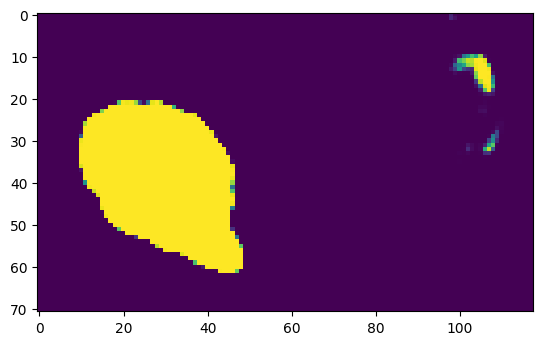

In [37]:
plt.imshow(cropped_predictions[0][:,:,1])

In [38]:
cropped_predictions[0][20][30]

array([1.0000000e+00, 2.4607804e-11], dtype=float32)

In [39]:
state=get_state(30,50,cropped_predictions[0])
print(state)

[1.6169448e-28 2.6215645e-31 7.0299535e-30 6.6626120e-29 3.9104565e-32
 4.3354544e-32 9.3717032e-28 3.1894688e-31 2.9621125e-31]


In [40]:
state=get_state(30,50,cropped_predictions[0])
action=dqn_solver.act(state)
print(action)
print(state)
new_state,reward=step(state,action,cropped_masks[0][30][50])
print(new_state)
print(reward)

1
[1.6169448e-28 2.6215645e-31 7.0299535e-30 6.6626120e-29 3.9104565e-32
 4.3354544e-32 9.3717032e-28 3.1894688e-31 2.9621125e-31]
[1.6169448e-28 2.6215645e-31 7.0299535e-30 6.6626120e-29 3.9104565e-32
 4.3354544e-32 9.3717032e-28 3.1894688e-31 2.9621125e-31]
0


In [41]:
cropped_images,cropped_masks,cropped_predictions,cropped_predicted_imgs,predicted_imgs=cropping([0],complete_model.unet,X_test,y_test,cushion=CUSHION)
    

In [42]:
cropped_masks[0][0][0]

0

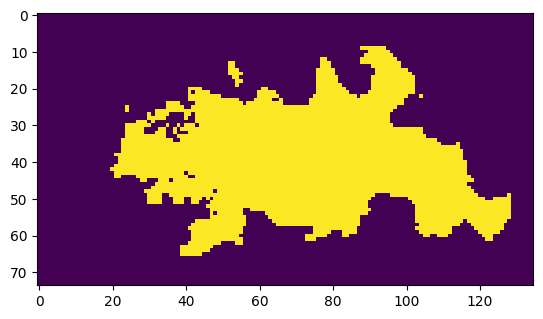

In [43]:
plt.imshow(cropped_masks[0])

-939.9000000001452


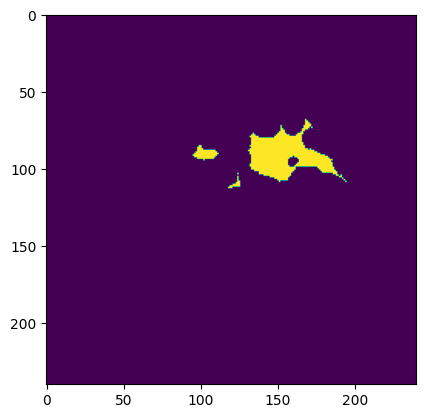

In [44]:
cropped_images,cropped_masks,cropped_predictions,cropped_predicted_imgs,predicted_imgs=cropping([0],complete_model.unet,X_test,y_test,cushion=CUSHION)
    
action_images=dqn_inference_loop(cropped_images,cropped_predictions,cropped_predicted_imgs,cropped_masks,all_actions,loops=10)
action_images_final=get_pixelwise_actions(action_images,predicted_imgs,cushion=CUSHION)

prediction=complete_model([np.expand_dims(X_test[0],0),action_images_final])
predicted_img_test=np.argmax(prediction, axis=-1)
plt.imshow(predicted_img_test[0])
plt.show()

In [45]:
dqn_solver.memory

deque([], maxlen=1000)

In [46]:
action_images_final[0][100,150,1]


0.0

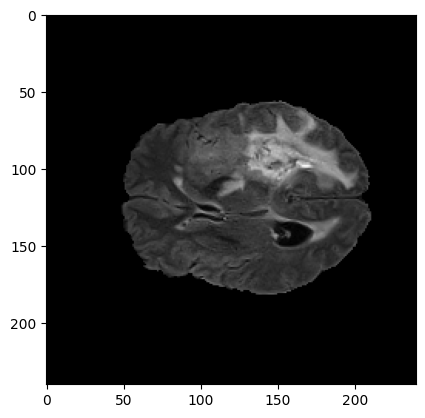

In [47]:
plt.imshow(X_test[0])

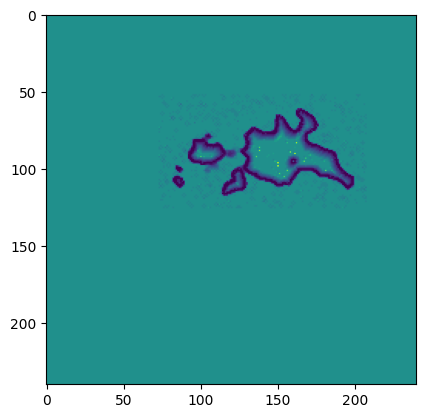

In [48]:
action_map=action_images_final[0][:,:,1]
action_map.shape
plt.imshow(action_map)

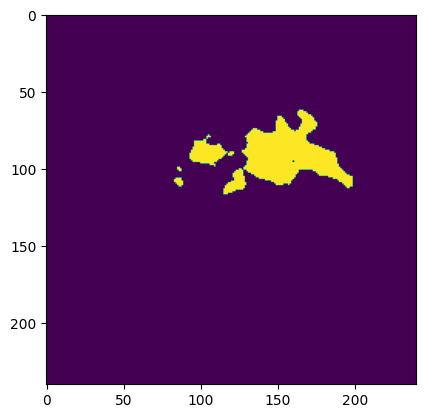

In [49]:
unet_pred=complete_model.get_preds(np.expand_dims(X_test[0],0))
plt.imshow(np.argmax(unet_pred[0], axis=-1))
plt.show()

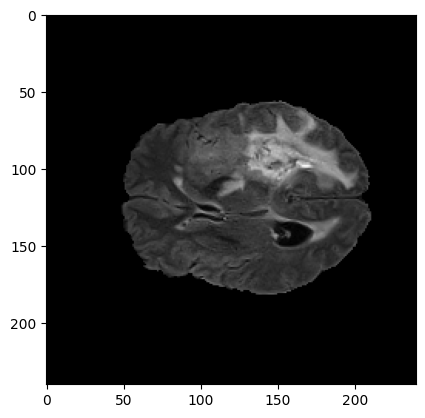

In [50]:
plt.imshow(X_test[0])
plt.show()

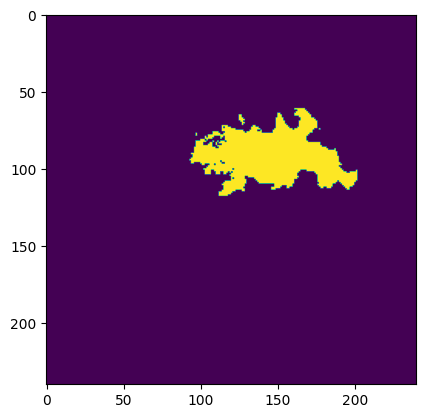

In [51]:
plt.imshow(np.argmax(y_test[0], axis=-1))
plt.show()

In [52]:
val, counts = np.unique(action_images_final, return_counts=True)
print(val)
print(counts)

[-1.  -0.9 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.3 -0.2 -0.2 -0.1 -0.1 -0.1
  0.   0.1  0.1  0.1  0.2  0.2  0.3  0.3  0.4  0.5  0.6  0.7  0.8  0.9
  1. ]
[   624    171    238    192    154    117    195    143      4    264
      1      1   1274      1 108442      1   1274      1      1    264
      4    143    195    117    154    192    238    171    624]


In [53]:
val, counts = np.unique(action_images_final, return_counts=True)
print(val)
print(counts)

[-1.  -0.9 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.3 -0.2 -0.2 -0.1 -0.1 -0.1
  0.   0.1  0.1  0.1  0.2  0.2  0.3  0.3  0.4  0.5  0.6  0.7  0.8  0.9
  1. ]
[   624    171    238    192    154    117    195    143      4    264
      1      1   1274      1 108442      1   1274      1      1    264
      4    143    195    117    154    192    238    171    624]


In [54]:
def DICE_COE(mask1, mask2):
    intersect = np.sum(mask1*mask2)
    fsum = np.sum(mask1)
    ssum = np.sum(mask2)
    dice = (2 * intersect ) / (fsum + ssum)
    dice = np.mean(dice)
    dice = round(dice, 3) # for easy reading
    return dice 

In [55]:
DICE_COE(predicted_img_test,np.argmax(y_test[0], axis=-1))

0.565

In [56]:
DICE_COE(np.argmax(unet_pred[0], axis=-1),np.argmax(y_test[0], axis=-1))

0.825